# Dreambooth
### Notebook implementation by Joe Penna (@MysteryGuitarM on Twitter) - Improvements by David Bielejeski

### Instructions
- Sign up for RunPod here: https://runpod.io/?ref=n8yfwyum
    - Note: That's my personal referral link. Please don't use it if we are mortal enemies.

- Click *Deploy* on either `SECURE CLOUD` or `COMMUNITY CLOUD`

- Follow the rest of the instructions in this video: https://www.youtube.com/watch?v=7m__xadX0z0#t=5m33.1s

Latest information on:
https://github.com/JoePenna/Dreambooth-Stable-Diffusion

## Build Environment

In [ ]:
# If running on Vast.AI, copy the code in this cell into a new notebook. Run it, then launch the `dreambooth_runpod_joepenna.ipynb` notebook from the jupyter interface.
!git clone https://github.com/JoePenna/Dreambooth-Stable-Diffusion

In [ ]:
# BUILD ENV
!pip install omegaconf
!pip install einops
!pip install pytorch-lightning==1.6.5
!pip install test-tube
!pip install transformers
!pip install kornia
!pip install -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
!pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip
!pip install setuptools==59.5.0
!pip install pillow==9.0.1
!pip install torchmetrics==0.6.0
!pip install -e .
!pip install protobuf==3.20.1
!pip install gdown
!pip install -qq diffusers["training"]==0.3.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"
!pip install huggingface_hub
!pip install ipywidgets==7.7.1
!pip install captionizer==1.0.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.7.7
    Uninstalling pytorch-lightning-1.7.7:
      Successfully uninstalled pytorch-lightning-1.7.7
  Preparing metadata (setup.py) ... done
  Created wheel for test-tube: filename=test_tube-0.7.5-py3-none-any.whl size=25328 sha256=df72de397e7b372cf15a7cac6249a630e4a1f44b3b1578abdde9d9d75d8e037a
  Stored in directory: /root/.cache/pip/wheels/28/d4/8b/1aeb47c0dedd931b8e6aec55a8091864a69ac6f0adc5b12ea9
Successfully built test-tube
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-transformers
  Running command git clone --filter=blob:none --quiet https://github.com/CompVis/taming-transformers.git /workspace/Dreambooth-Stable-Diffusion/src/taming-tr

In [ ]:
# Hugging Face Login
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Download the 1.4 sd model
from IPython.display import clear_output

from huggingface_hub import hf_hub_download
downloaded_model_path = hf_hub_download(
 repo_id="CompVis/stable-diffusion-v-1-4-original",
 filename="sd-v1-4.ckpt",
 use_auth_token=True
)

# Move the sd-v1-4.ckpt to the root of this directory as "model.ckpt"
actual_locations_of_model_blob = !readlink -f {downloaded_model_path}
!mv {actual_locations_of_model_blob[-1]} model.ckpt
clear_output()
print("✅ model.ckpt successfully downloaded")

✅ model.ckpt successfully downloaded


# Regularization Images (Skip this section if you are uploading your own or using the provided images)

Training teaches your new model both your token **but** re-trains your class simultaneously.

From cursory testing, it does not seem like reg images affect the model too much. However, they do affect your class greatly, which will in turn affect your generations.

You can either generate your images here, or use the repos below to quickly download 1500 images.

In [ ]:
# GENERATE 200 images - Optional
self_generated_files_prompt = "person" #@param {type:"string"}
self_generated_files_count = 200 #@param {type:"integer"}

!python scripts/stable_txt2img.py \
 --seed 10 \
 --ddim_eta 0.0 \
 --n_samples 1 \
 --n_iter {self_generated_files_count} \
 --scale 10.0 \
 --ddim_steps 50 \
 --ckpt model.ckpt \
 --prompt {self_generated_files_prompt}

dataset=self_generated_files_prompt

!mkdir -p regularization_images/{dataset}
!mv outputs/txt2img-samples/*.png regularization_images/{dataset}

In [ ]:
# Zip up the files for downloading and reuse.
# Download this file locally so you can reuse during another training on this dataset
!apt-get install -y zip
!zip -r regularization_images.zip regularization_images/{dataset}

# Download pre-generated regularization images
We've created the following image sets

`man_euler` - provided by Niko Pueringer (Corridor Digital) - euler @ 40 steps, CFG 7.5
`man_unsplash` - pictures from various photographers
`person_ddim`
`woman_ddim` - provided by David Bielejeski - ddim @ 50 steps, CFG 10.0
`person_ddim` is recommended

In [ ]:
#Download Regularization Images

dataset="person_ddim" #@param ["man_euler", "man_unsplash", "person_ddim", "woman_ddim", "blonde_woman"]
!git clone https://github.com/djbielejeski/Stable-Diffusion-Regularization-Images-{dataset}.git

!mkdir -p regularization_images/{dataset}
!mv -v Stable-Diffusion-Regularization-Images-{dataset}/{dataset}/*.* regularization_images/{dataset}

Cloning into 'Stable-Diffusion-Regularization-Images-person_ddim'...
remote: Enumerating objects: 1503, done.
remote: Total 1503 (delta 0), reused 0 (delta 0), pack-reused 1503
Receiving objects: 100% (1503/1503), 657.41 MiB | 25.93 MiB/s, done.
Updating files: 100% (1500/1500), done.
renamed 'Stable-Diffusion-Regularization-Images-person_ddim/person_ddim/person_ddim_00000.png' -> 'regularization_images/person_ddim/person_ddim_00000.png'
renamed 'Stable-Diffusion-Regularization-Images-person_ddim/person_ddim/person_ddim_00001.png' -> 'regularization_images/person_ddim/person_ddim_00001.png'
renamed 'Stable-Diffusion-Regularization-Images-person_ddim/person_ddim/person_ddim_00002.png' -> 'regularization_images/person_ddim/person_ddim_00002.png'
renamed 'Stable-Diffusion-Regularization-Images-person_ddim/person_ddim/person_ddim_00003.png' -> 'regularization_images/person_ddim/person_ddim_00003.png'
renamed 'Stable-Diffusion-Regularization-Images-person_ddim/person_ddim/person_ddim_00004.

# Upload your training images
Upload 10-20 images of someone to

```
/workspace/Dreambooth-Stable-Diffusion/training_images
```

WARNING: Be sure to upload an *even* amount of images, otherwise the training inexplicably stops at 1500 steps.

*   2-3 full body
*   3-5 upper body
*   5-12 close-up on face

The images should be:

- as close as possible to the kind of images you're trying to make

In [25]:
#@markdown Add here the URLs to the images of the subject you are adding
urls = [
 "https://imgur.com/BSqlo8w.png",
 "https://imgur.com/CiiYlg5.png",
 "https://imgur.com/7qsq4tm.png",
 "https://imgur.com/TJQovv0.png",
 "https://imgur.com/etAhoRM.png",
 "https://imgur.com/PNZ19x4.png",
 "https://imgur.com/RAfxGfX.png",
 "https://imgur.com/NpG9AC4.png",
 "https://imgur.com/vS5POQs.png",
 "https://imgur.com/iW7QpQU.png",
 "https://imgur.com/G8vOA55.png",
 "https://imgur.com/u2UEoUV.png",
 "https://imgur.com/dQJbbmS.png",
 "https://imgur.com/Q3YarlJ.png",
 "https://imgur.com/8UZKxMk.png",
 "https://imgur.com/tZBzlPi.png",
 # You can add additional images here -- about 20-30 images in different
]

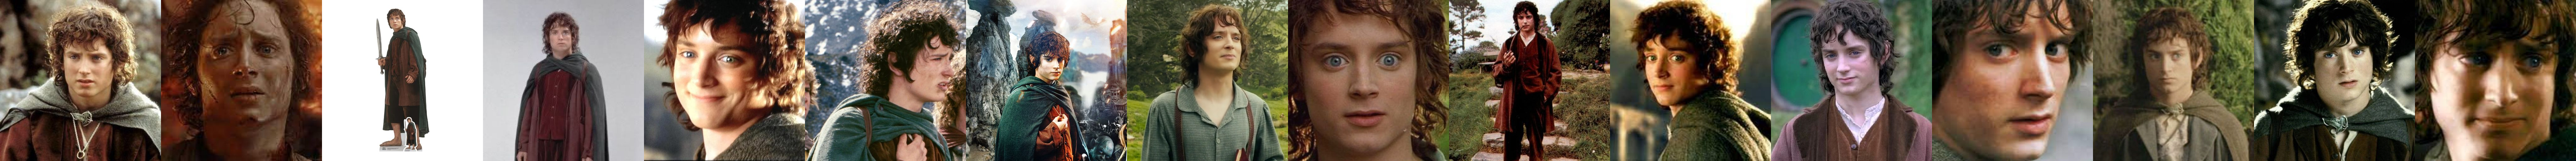

In [26]:
#@title Download and check the images you have just added
import os
import requests
from io import BytesIO
from PIL import Image


def image_grid(imgs, rows, cols):
 assert len(imgs) == rows*cols

 w, h = imgs[0].size
 grid = Image.new('RGB', size=(cols*w, rows*h))
 grid_w, grid_h = grid.size

 for i, img in enumerate(imgs):
  grid.paste(img, box=(i%cols*w, i//cols*h))
 return grid

def download_image(url):
 try:
  response = requests.get(url)
 except:
  return None
 return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./training_images"
if not os.path.exists(save_path):
 os.mkdir(save_path)
[image.save(f"{save_path}/{i}.png", format="png") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

## Training

If training a person or subject, keep an eye on your project's `logs/{folder}/images/train/samples_scaled_gs-00xxxx` generations.

If training a style, keep an eye on your project's `logs/{folder}/images/train/samples_gs-00xxxx` generations.

In [32]:
# Training

# This isn't used for training, just to help you remember what your trained into the model.
project_name = "frodo_dreambooth"

# MAX STEPS
# How many steps do you want to train for?
max_training_steps = 2000

# Match class_word to the category of the regularization images you chose above.
class_word = "person" # typical uses are "man", "person", "woman"

# This is the unique token you are incorporating into the stable diffusion model.
token = "frodo"


reg_data_root = "/workspace/Dreambooth-Stable-Diffusion/regularization_images/" + dataset

!rm -rf training_images/.ipynb_checkpoints
!python "main.py" \
 --base configs/stable-diffusion/v1-finetune_unfrozen.yaml \
 -t \
 --actual_resume "model.ckpt" \
 --reg_data_root "{reg_data_root}" \
 -n "{project_name}" \
 --gpus 0, \
 --data_root "/workspace/Dreambooth-Stable-Diffusion/training_images" \
 --max_training_steps {max_training_steps} \
 --class_word "{class_word}" \
 --token "{token}" \
 --no-test

Global seed set to 23
Running on GPUs 0,
Loading model from model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 64, 64) = 16384 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.8.layer_norm2.weight', 'vision_model.encoder.layers.8.mlp.fc1.bias', 'visual_projection.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.18.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias'

## Copy and name the checkpoint file

In [ ]:
# Copy the checkpoint into our `trained_models` folder

directory_paths = !ls -d logs/*
last_checkpoint_file = directory_paths[-1] + "/checkpoints/last.ckpt"
training_images = !find training_images/*
date_string = !date +"%Y-%m-%dT%H-%M-%S"
file_name = date_string[-1] + "_" + project_name + "_" + str(len(training_images)) + "_training_images_" +  str(max_training_steps) + "_max_training_steps_" + token + "_token_" + class_word + "_class_word.ckpt"

file_name = file_name.replace(" ", "_")

!mkdir -p trained_models
!mv "{last_checkpoint_file}" "trained_models/{file_name}"

print("Download your trained model file from trained_models/" + file_name + " and use in your favorite Stable Diffusion repo!")

# Optional - Upload to google drive
* run the following commands in a new `terminal` in the `Dreambooth-Stable-Diffusion` directory
* `chmod +x ./gdrive`
* `./gdrive about`
* `paste your token here after navigating to the link`
* `./gdrive upload trained_models/{file_name.ckpt}`

# Big Important Note!

The way to use your token is `<token> <class>` ie `joepenna person` and not just `joepenna`

## Generate Images With Your Trained Model!

In [ ]:
!python scripts/stable_txt2img.py \
 --ddim_eta 0.0 \
 --n_samples 1 \
 --n_iter 4 \
 --scale 7.0 \
 --ddim_steps 50 \
 --ckpt "/workspace/Dreambooth-Stable-Diffusion/trained_models/{file_name}" \
 --prompt "joepenna person as a masterpiece portrait painting by John Singer Sargent in the style of Rembrandt"